In [198]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.linear_model import LinearRegression
from skimage.transform import rotate,warp



In [206]:
def show_bgr(frame,w=20):
    plt.figure(figsize=(w,int(w/1.6)))
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()


In [279]:

def annotate_image(frame, cx, cy, w, h):
    # Prepare the text to be displayed
    text = f"Centroid: ({cx}, {cy}), Size: {w}x{h} pixels"
    
    # Set the font, scale, color, and thickness for the text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    color = (0, 255, 255)  # Bright yellow color (BGR)
    thickness = 2
    
    # Get the text size to position it correctly at the bottom
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_width, text_height = text_size
    
    # Calculate the position for the text at the bottom of the image
    x_pos = (frame.shape[1] - text_width) // 2  # Centered horizontally
    y_pos = frame.shape[0] - 10  # Just above the bottom border
    
    # Add the text to the image
    cv2.putText(frame, text, (x_pos, y_pos), font, font_scale, color, thickness)
    
    return frame


In [208]:
def enhance_image(image_path):
    image = cv2.imread(image_path)
    print(image)
    # Convert to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L-channel with A and B channels
    enhanced_lab = cv2.merge((cl, a, b))

    # Convert back to BGR color space
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    return enhanced_image

In [209]:
def detect_sky(image, do_morphology=True):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # --------------------------------------------------
    # 1) Threshold for "blue sky"
    #    (Hue around 90-130, depending on the type of sky)
    # --------------------------------------------------
    lower_blue = np.array([90, 50, 50])   # lower bound for blue
    upper_blue = np.array([130, 255, 255])  # upper bound for blue
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)

    # --------------------------------------------------
    # 2) Threshold for "white clouds"
    #    (Low saturation, high value)
    #    Typically Hue is “don't care”, so we might do:
    # --------------------------------------------------
    lower_white = np.array([0, 0, 200])    # near white
    upper_white = np.array([179, 50, 255]) # upper limit for "white" in HSV
    mask_white = cv2.inRange(hsv, lower_white, upper_white)

    # Combine the two
    sky_mask = cv2.bitwise_or(mask_blue, mask_white)

    # Optional: morphological ops to remove noise and fill small holes
    if do_morphology:
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        sky_mask = cv2.morphologyEx(sky_mask, cv2.MORPH_CLOSE, kernel)
        sky_mask = cv2.morphologyEx(sky_mask, cv2.MORPH_OPEN, kernel)

    return sky_mask

def estimate_horizon_line_by_edges(image):
    edges = feature.canny(image.astype(float),sigma=1)

    edge_pixels = np.column_stack(np.where(edges))
    if edge_pixels.shape[0]>1:
        X = edge_pixels[:,1].reshape(-1,1)
        y = edge_pixels[:,0]
        model = LinearRegression()
        model.fit(X,y)
        slope = model.coef_[0]
        intercept = model.intercept_

        return slope,intercept

def rectify_horizon(image, slope, intercept):
    angle = np.degrees(np.arctan(slope))
    rotated_image = rotate(image,angle,resize=True,preserve_range=True)
    ri = rotated_image.astype(np.uint8)
    ri = translate_vertical(ri,-1*intercept*s)
    return ri

def downsampler_gray(image,scale_factor=2):
    h,w = image.shape
    nw = w//scale_factor
    nh = h//scale_factor
    downsampled_image = cv2.resize(image,(nw,nh),interpolation=cv2.INTER_NEAREST)
    return downsampled_image
        

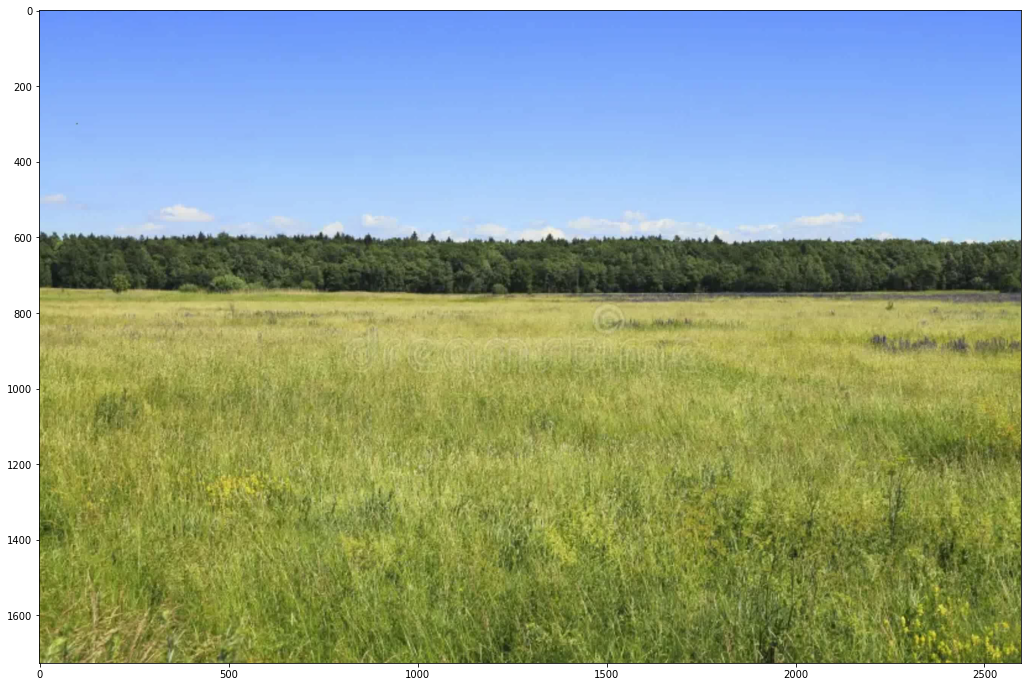

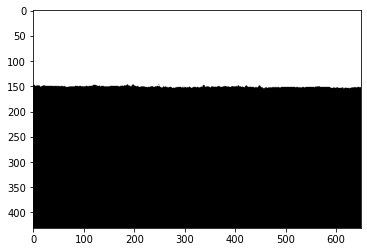

Estimated horizon line: y = 0.005 x + 149.240
0 149 648 152


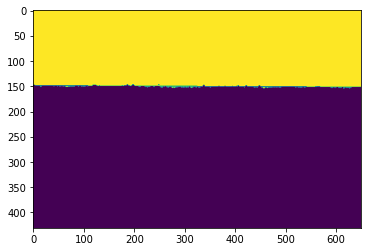

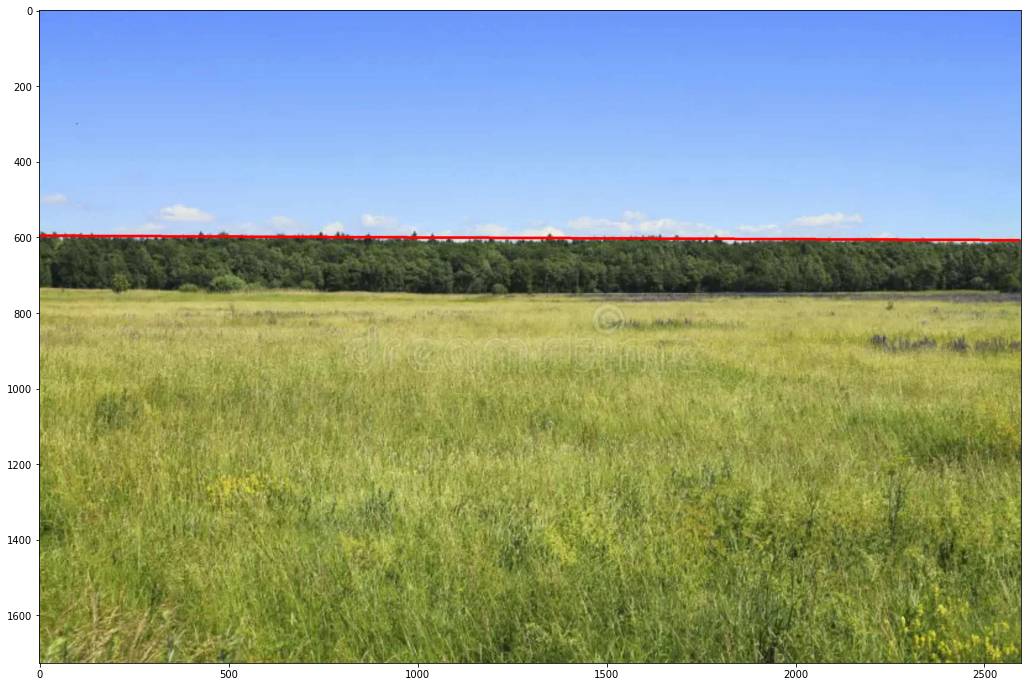

In [225]:
#base_image = cv2.imread("images/base_images/horizon_2.png")
video_path = "synth_track_video.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    raise ValueError(f"Error opening video file: {video_path}")

frame_number = 1
# Set the frame position (0-based index)
frame_index = frame_number - 1
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

# Read the frame
ret, frame = cap.read()
show_bgr(frame)

base_image = frame
image = base_image#[400:1800, 1100:1500]
s = 4
sky_mask = detect_sky(image)
image = downsampler(sky_mask,scale_factor=s)

plt.imshow(image,cmap = 'gray')
plt.show()
#plt.imshow(img)

slope, intercept = estimate_horizon_line_by_edges(image)
print("Estimated horizon line: y = {:.3f} x + {:.3f}".format(slope, intercept))

h,w = image.shape
# 4) (Optional) Visualize the result
#    Draw the detected horizon line on a copy of the image
x_start, x_end = 0, w - 1
y_start = int(slope * x_start + intercept)
y_end   = int(slope * x_end   + intercept)

print(x_start,y_start,x_end,y_end)
cv2.line(image, (x_start, y_start), (x_end, y_end), (0, 0, 255), 1)


plt.imshow(image)
plt.show()


cv2.line(base_image, (x_start*s, y_start*s), (x_end*s, y_end*s), (0, 0, 255), 5)
base_image_rgb = cv2.cvtColor(base_image, cv2.COLOR_BGR2RGB)

show_bgr(base_image)

In [211]:
def find_and_draw_small_dark_object(image, w, y_start, y_end, threshold_value=50):

    # 1. Extract the region of interest (ROI)
    #    Note: ROI = image[y_start:y_end, 0:w]
    #    Make a copy, because we don't want to modify the original region data.
    roi = image[y_start:y_end, 0:w].copy()
    
    # 2. Convert ROI to grayscale
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

    # 3. Threshold to find dark pixels
    #    Everything below 'threshold_value' is considered dark (white in the mask),
    #    everything above is black in the mask.
    #    You may invert this if your thresholding logic is reversed.
    _, mask = cv2.threshold(gray_roi, threshold_value, 255, cv2.THRESH_BINARY_INV)

    # (Optional) Apply morphological operations to reduce noise
    # For a small object, try opening to remove small noise dots:
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # 4. Find contours of the thresholded mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        # No contours found
        return image.copy(), None
    
    # 5. Select the largest contour by area
    largest_contour = max(contours, key=cv2.contourArea)
    
    # 6. Compute bounding box for that contour
    x_roi, y_roi, w_roi, h_roi = cv2.boundingRect(largest_contour)
    
    # Convert bounding box coordinates back to the original image space
    x = x_roi  # since x_roi is relative to 0 in ROI
    y = y_start + y_roi  # offset the y by y_start
    
    bounding_box = (x, y, w_roi, h_roi)
    
    # 7. Draw the bounding box on a copy of the original image
    output_image = image.copy()
    cv2.rectangle(output_image, (x, y), (x + w_roi, y + h_roi), (0, 0, 255), 2)
    
    return output_image, bounding_box

152


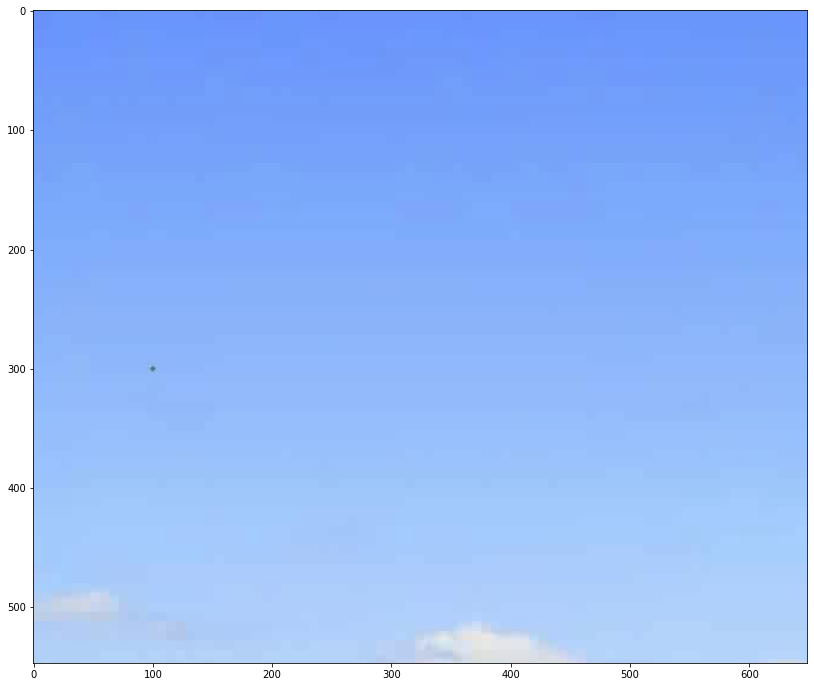

In [230]:
img = base_image
# Suppose your search region is top-left corner at (0, y_start),
# top-right corner at (w, y_start), and
# bottom-left corner at (0, y_end), bottom-right corner at (w, y_end)

# Find the object and draw the bounding box
#result_img, bbox = find_and_draw_small_dark_object(img, w, y_start, y_end, threshold_value=1)
print(y_end)
r = img[0:int(.9*y_end*s),0:w]
show_bgr(r)
#if bbox is not None:
#    print("Bounding box for the dark object:", bbox)
#else:
#    print("No dark object found in the specified region.")


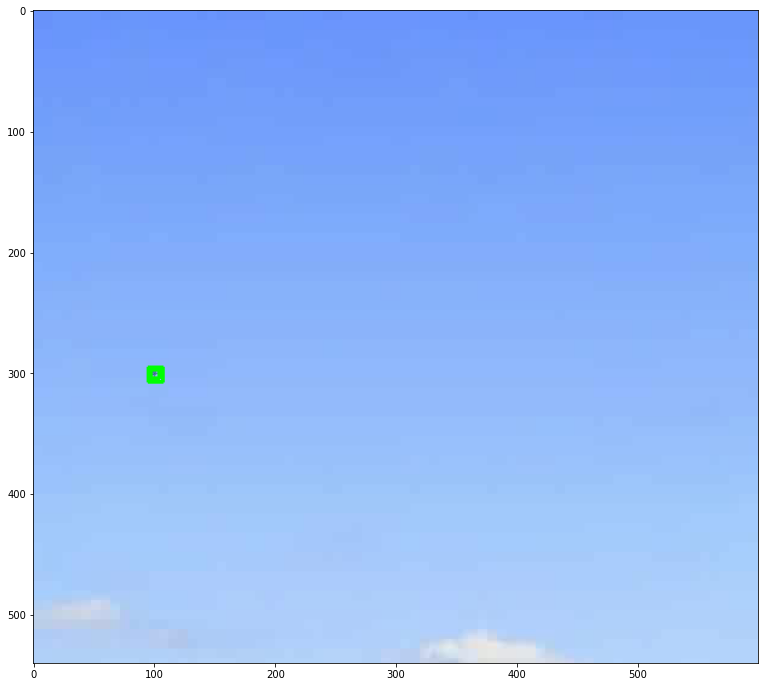

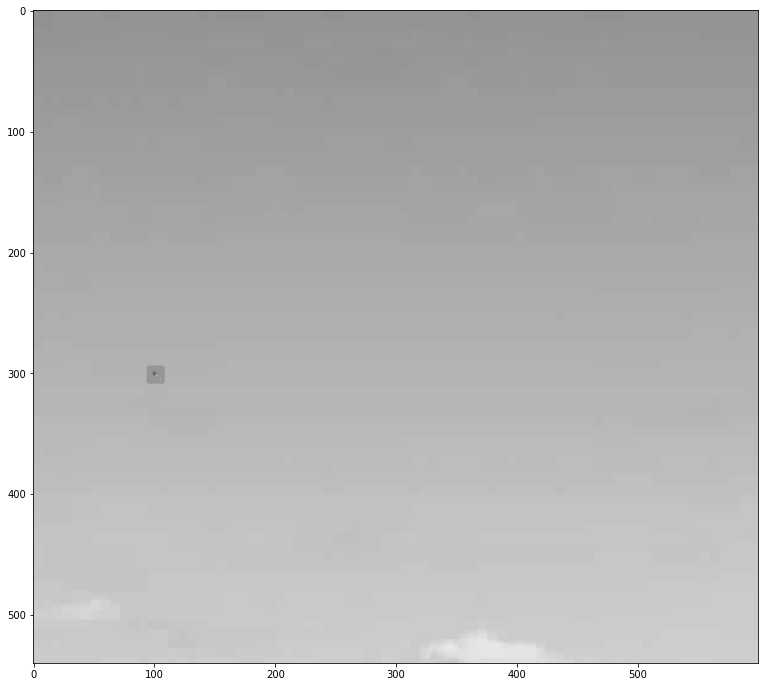

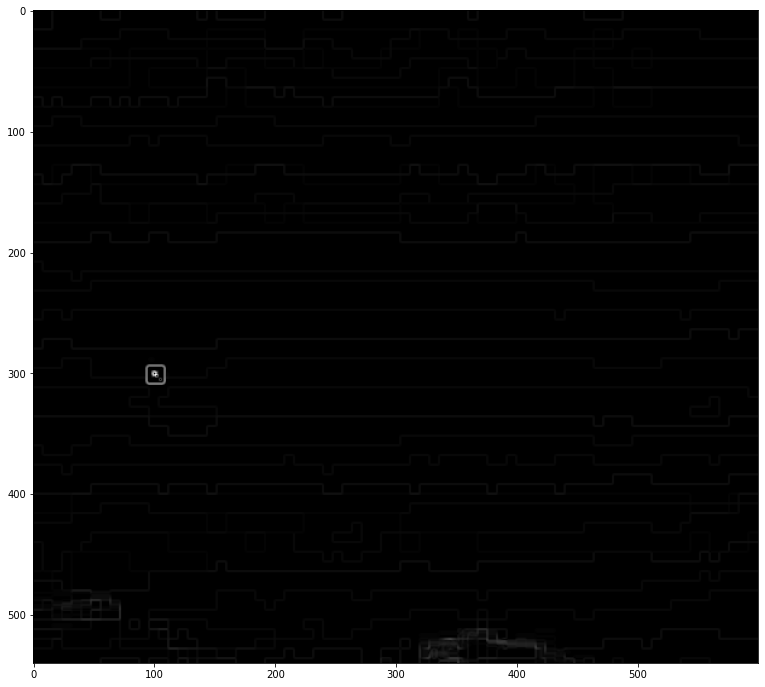

(93, 293, 17, 17)
101 301


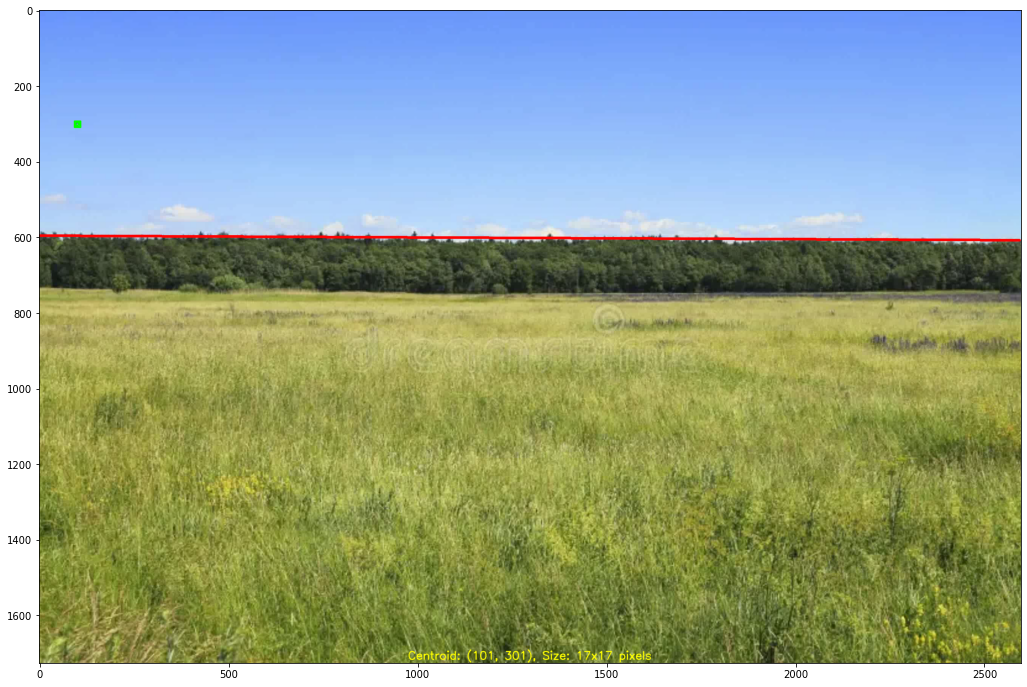

In [281]:
img = base_image

y_start = 0
y_end = int(600*.9)
w = 600
roi = img[y_start:y_end, 0:w].copy()
show_bgr(roi)
threshold_value = 200
# 2. Convert ROI to grayscale
gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

show_bgr(gray_roi)

kernel_size=(3, 3)
sigma=0.5
gaussian_blur = cv2.GaussianBlur(gray_roi, kernel_size, sigma)


sobel_threshold=50
# Apply Laplacian
#laplacian = cv2.Laplacian(gaussian_blur, cv2.CV_64F)
# Convert back to uint8
#laplacian = cv2.convertScaleAbs(laplacian)

#canny_edges = cv2.Canny(gray_roi, threshold1=50, threshold2=150)
sobelx = cv2.Sobel(gray_roi, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray_roi, cv2.CV_64F, 0, 1, ksize=3)
sobel = cv2.magnitude(sobelx, sobely)
sobel = cv2.convertScaleAbs(sobel)

show_bgr(sobel)

_, mask = cv2.threshold(sobel, sobel_threshold, 255, cv2.THRESH_BINARY)

# -- Optional: Morphological operations (e.g., close small gaps) --
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
# mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# -- 3. Find contours in the binary mask --
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_contour)
bounding_box = (x, y, w, h)

# Centroid using image moments
M = cv2.moments(largest_contour)
if M["m00"] != 0:
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    centroid = (cx, cy)
else:
    # Fallback: if area is zero (degenerate contour),
    # pick the center of the bounding box
    centroid = (x + w // 2, y + h // 2)

print(bounding_box)
print(cx,cy)

# Draw bounding box and centroid on the original image
cv2.rectangle(base_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
#cv2.circle(roi, (cx, cy), 4, (0, 0, 255), -1)
annotate_image(base_image, cx, cy, w, h)

show_bgr(base_image)



In [188]:
def pad_image_center(base_image,image, scale_factor=2, padding_color=(0, 0, 0)):
    """
    Pads the input image to make it 'scale_factor' times larger in both width and height,
    and centers the original image in the padded image.

    Parameters:
        image (numpy.ndarray): The original image.
        scale_factor (int, optional): Factor to scale the dimensions. Default is 2.
        padding_color (tuple, optional): Color of the padding in BGR format. Default is black.

    Returns:
        numpy.ndarray: The padded image with the original image centered.
    """
    if not isinstance(scale_factor, int) or scale_factor < 1:
        raise ValueError("scale_factor must be a positive integer (e.g., 2 for doubling size).")

    original_height, original_width = base_image.shape[:2]
    new_width = 5000#original_width * scale_factor
    new_height = 5000#original_height * scale_factor

    # Determine the number of channels (e.g., 3 for BGR, 1 for grayscale)
    if len(image.shape) == 3:
        channels = image.shape[2]
        # Create a new image with the desired size and padding color
        padded_image = np.full((new_height, new_width, channels), padding_color, dtype=image.dtype)
    else:
        # Grayscale image
        padded_image = np.full((new_height, new_width), padding_color[0], dtype=image.dtype)

    # Calculate the top-left corner for centering the original image
    x_offset = (new_width - original_width) // 2
    y_offset = (new_height - original_height) // 2

    # Place the original image in the center of the padded image
    padded_image[y_offset:y_offset + original_height, x_offset:x_offset + original_width] = image

    return padded_image


In [152]:
"""
def add_vertical_padding(image, padding_amount):
    # Add padding to top and bottom with black color
    padding_amount = abs(padding_amount)
    padded_image = cv2.copyMakeBorder(
        image,
        top=int(padding_amount),
        bottom=int(padding_amount),
        left=0,
        right=0,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # You can change the padding color if needed
    )
    return padded_image
"""

In [173]:
def translate_vertical(image, distance):
    """
    Translates the given image vertically by the specified distance.

    Parameters:
        image (numpy.ndarray): The input image.
        distance (int): The number of pixels to move the image downwards.

    Returns:
        numpy.ndarray: The translated image.
    """
    rows, cols = image.shape[:2]
    
    # Define the translation matrix: no horizontal shift, vertical shift by 'distance' pixels
    M = np.float32([[1, 0, 0],
                    [0, 1, distance]])
    # Apply the affine transformation
    translated_image = cv2.warpAffine(image, M, (cols, rows))
    return translated_image


In [195]:




print(intercept*s)
rq = pad_image_center(base_image, base_image, scale_factor=2, padding_color=(0, 0, 0))

plt.figure(figsize=(16, 10)) 
plt.imshow(rq)
#plt.gca().set(ylim=(result_cv2_rgb.shape[0],-2000))
#plt.ylim([-2000,2000])
#
plt.show()



result = rectify_horizon(rq, slope, intercept)
#result = cv2.flip(result,0)
plt.figure(figsize=(16, 10)) 
result_cv2_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.imshow(result_cv2_rgb)
plt.gca().set(ylim=(5000,0))
plt.gca().set(xlim=(0,5000))

#plt.ylim([-2000,2000])
#
plt.show()




895.0270724703039


AttributeError: 'NoneType' object has no attribute 'shape'